In [7]:
# Importing neccessary packages
import numpy as np
import tensorflow as tf
import os
from utils import get_data_generators

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
NUM_CLASSES = 11

In [10]:
os.listdir('./training/')[0].split('_')[1]

'158.jpg'

In [0]:
# Data augmentation for regularization and adding some extra training samples

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rescale=1.0/255.0,
    horizontal_flip=True, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=30
)

In [0]:
TARGET_DIM = 224
BATCH_SIZE = 32

In [25]:
train_generator, validation_generator = get_data_generators(datagen, TARGET_DIM, BATCH_SIZE)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [26]:
# Lets try the Xception architecture

base_model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False, 
    weights='imagenet', 
    input_shape=(TARGET_DIM, TARGET_DIM, 3)
)

17227776/17225924 [==============================] - 0s 0us/step


In [27]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [28]:
print('Layers in Mobilenet: ' + str(len(base_model.layers)))

Layers in Mobilenet: 87


In [0]:
preds = base_model.output
preds = tf.keras.layers.Flatten()(preds)
preds = tf.keras.layers.Dense(512, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dropout(0.5)(preds)
preds = tf.keras.layers.Dense(256, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.BatchNormalization()(preds)
preds = tf.keras.layers.Dropout(0.4)(preds)
preds = tf.keras.layers.Dense(128, activation=tf.nn.relu)(preds)
preds = tf.keras.layers.Dense(11, activation=tf.nn.softmax)(preds)

In [0]:
model = tf.keras.models.Model(base_model.input, preds)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [32]:
model.layers[-15].name

'conv_dw_13'

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005, momentum=0.09),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [0]:
# Create directory in drive for storing model
!mkdir drive/My\ Drive/food_11_weights

In [0]:
# Lets define checkpoint for model saving
filepath="./drive/My Drive/food_11_weights/mobilenet-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
# Freeze mobilenet layers and train only newly added layers

for layers in model.layers[:-15]:
    layers.trainable = False

for layers in model.layers[-15:]:
    layers.trainable = True

In [0]:
# Lets stop training when model acheives desired accuracy

class ModelCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs):
        # Check if validation accuracy is above 90% then stop training
        if logs['acc'] >= 0.95:
            print('Model reached its target')
            self.model.stop_training = True
            
model_callback = ModelCallback()

In [37]:
#Let's train the model 50 epochs as it will take a lot of time

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, model_callback],
    epochs=50
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
308/308 [==============================] - ETA: 0s - loss: 2.4602 - acc: 0.1678
Epoch 00001: val_acc improved from -inf to 0.04264, saving model to ./drive/My Drive/food_11_weights/mobilenet-01-0.04.hdf5
308/308 [==============================] - 218s 709ms/step - loss: 2.4602 - acc: 0.1678 - val_loss: 2.5526 - val_acc: 0.0426
Epoch 2/50
308/308 [==============================] - ETA: 0s - loss: 2.0988 - acc: 0.2580
Epoch 00002: val_acc improved from 0.04264 to 0.22050, saving model to ./drive/My Drive/food_11_weights/mobilenet-02-0.22.hdf5
308/308 [==============================] - 218s 708ms/step - loss: 2.0988 - acc: 0.2580 - val_loss: 3.3642 - val_acc: 0.2205
Epoch 3/50
308/308 [==============================] - ETA: 0s - loss: 1.9596 - acc: 0.3063
Epoch 00003: val_acc did not improve from 0.22050
308/308 [==============================] - 218s 707ms/step - loss: 1.9596 - acc: 0.3063 - val_loss: 

In [38]:
model.history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [0]:
history = model.history.history

Text(0, 0.5, 'Accuracy')

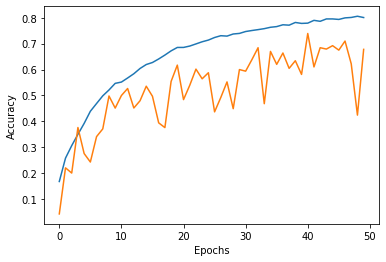

In [40]:
plt.plot(range(50), history['acc'])
plt.plot(range(50), history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Observations:

The validation accuracy is far from training accuracy so model is starting to overfit on training data.

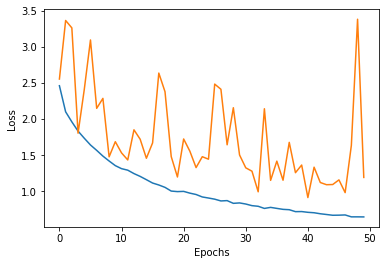

In [41]:
plt.plot(range(50), history['loss'])
plt.plot(range(50), history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Training results:

No of epochs: 50<br>
Learning rate: 0.005<br>
Momentum: 0.09<br>
Optimizer: RMSprop<br>

### Best model results 
Training accuracy: 0.8008<br>
Validation accuracy: 0.73919<br>
Found at epoch: 41<br>